# __Predicting Listing Gains in the Indian IPO Market Using TensorFlow__

For this project we'll play the role of a data scientist with an investment firm that is interested in investing in the Initial Public Offerings (IPO) in the Indian Market. We'll atempt to build a deep learning classification model that will determine if there will be a percentage increase to the share price of a company.

The dataset we'll use comed from [moneycontrol](https://www.moneycontrol.com/ipo/listed-ipos/?classic=true).

The data consists of the following columns:

1. `Date`: date when the IPO was listed

2. `IPOName`: name of the IPO

3. `Issue_Size`: size of the IPO issue, in INR Crores

4. `Subscription_QIB`: number of times the IPO was subscribed by the QIB (Qualified Institutional Buyer) investor category

5. `Subscription_HNI`: number of times the IPO was subscribed by the HNI (High Networth Individual) investor category

6. `Subscription_RII`: number of times the IPO was subscribed by the RII (Retail Individual Investors) investor category

7. `Subscription_Total`: total number of times the IPO was subscribed overall

8. `Issue_Price`: the price in INR at which the IPO was issued

9. `Listing_Gains_Percent`: is the percentage gain in the listing price over the issue price

We have the dataset saved under the name `Indian_IPO_Market_Data.csv`, and we'll load the necessary libraries below:

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

## __Loading the Data__

We will first get the data into a dataframe, and then we'll explore the data statistics:

In [2]:
ipo = pd.read_csv('Indian_IPO_Market_Data.csv')

In [3]:
print(ipo.head())
print(ipo.tail())

      Date           IPOName  Issue_Size  Subscription_QIB  Subscription_HNI  \
0  03/02/10    Infinite Comp      189.80             48.44            106.02   
1  08/02/10    Jubilant Food      328.70             59.39             51.95   
2  15/02/10    Syncom Health       56.25              0.99             16.60   
3  15/02/10  Vascon Engineer      199.80              1.12              3.65   
4  19/02/10      Thangamayil        0.00              0.52              1.52   

   Subscription_RII  Subscription_Total  Issue_Price  Listing_Gains_Percent  
0             11.08               43.22          165                  11.82  
1              3.79               31.11          145                 -84.21  
2              6.25                5.17           75                  17.13  
3              0.62                1.22          165                 -11.28  
4              2.26                1.12           75                  -5.20  
        Date           IPOName  Issue_Size  Subscri

In [4]:
print(ipo.shape)

(319, 9)


In [5]:
print(ipo.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319 entries, 0 to 318
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Date                   319 non-null    object 
 1   IPOName                319 non-null    object 
 2   Issue_Size             319 non-null    float64
 3   Subscription_QIB       319 non-null    float64
 4   Subscription_HNI       319 non-null    float64
 5   Subscription_RII       319 non-null    float64
 6   Subscription_Total     319 non-null    float64
 7   Issue_Price            319 non-null    int64  
 8   Listing_Gains_Percent  319 non-null    float64
dtypes: float64(6), int64(1), object(2)
memory usage: 22.6+ KB
None


In [6]:
print(ipo['Listing_Gains_Percent'].describe())

count    319.000000
mean       4.742696
std       47.650946
min      -97.150000
25%      -11.555000
50%        1.810000
75%       25.310000
max      270.400000
Name: Listing_Gains_Percent, dtype: float64


In [7]:
print(ipo.describe())

         Issue_Size  Subscription_QIB  Subscription_HNI  Subscription_RII  \
count    319.000000        319.000000        319.000000        319.000000   
mean    1192.859969         25.684138         70.091379          8.561599   
std     2384.643786         40.716782        142.454416         14.508670   
min        0.000000          0.000000          0.000000          0.000000   
25%      169.005000          1.150000          1.255000          1.275000   
50%      496.250000          4.940000          5.070000          3.420000   
75%     1100.000000         34.635000         62.095000          8.605000   
max    21000.000000        215.450000        958.070000        119.440000   

       Subscription_Total  Issue_Price  Listing_Gains_Percent  
count          319.000000   319.000000             319.000000  
mean            27.447147   375.128527               4.742696  
std             48.772203   353.897614              47.650946  
min              0.000000     0.000000            

### __Initial Findings:__

1. We have 319 rows and 9 columns, 7 of which are numerical. The other two are listing dates and the names of said listings
2. No columns have null values
3. Percentage changes in listings go from -97% to 270%, with the mean being 4.74%
4. Issue Size and subscriptions all have wide ranges and will need to be normalized
5. `Listing_Gains_Percent` (our target variable) is continuous, so we'll have to convert it into a categorical column for a classigication model


## __Exploring the Data__

We've seen that our target variable is continuous and we have to make it categorical for our intended model to work. We will now create a new variable for this, input null values if present, and select columns for modeling:

In [8]:
ipo['Listing_Gains_Profit'] = np.where(ipo['Listing_Gains_Percent']>0.0, 1, 0)

print('There are {} null values in this new column'.format(ipo['Listing_Gains_Profit'].isna().sum()))

There are 0 null values in this new column


In [9]:
print(ipo['Listing_Gains_Profit'].value_counts(normalize = True))

1    0.545455
0    0.454545
Name: Listing_Gains_Profit, dtype: float64


Roughly 55% of listings present any profits, so this dataset is fairly balanced. We will use a mix of issue sizes and subcription numbers by category to try and predict this, so we will not need the name of the listing and the date. We also no longer need the percent change in the listing, so we can drop this as well.

In [10]:
ipo.drop(columns = ['Date ', 'IPOName', 'Listing_Gains_Percent'], axis = 1, inplace = True)

## __Data Visualization__

Now that we have a target variable and predictors, we can explore how said predictors act in relation to profit through the use of visualizations:

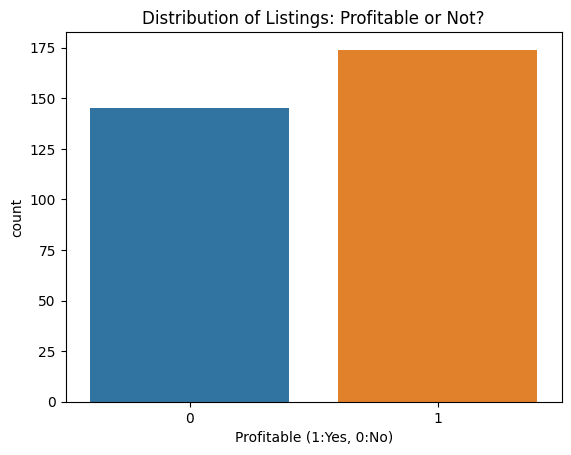

In [11]:
sns.countplot(ipo, x = 'Listing_Gains_Profit').set(title = 'Distribution of Listings: Profitable or Not?')
plt.xlabel('Profitable (1:Yes, 0:No)')
plt.show()

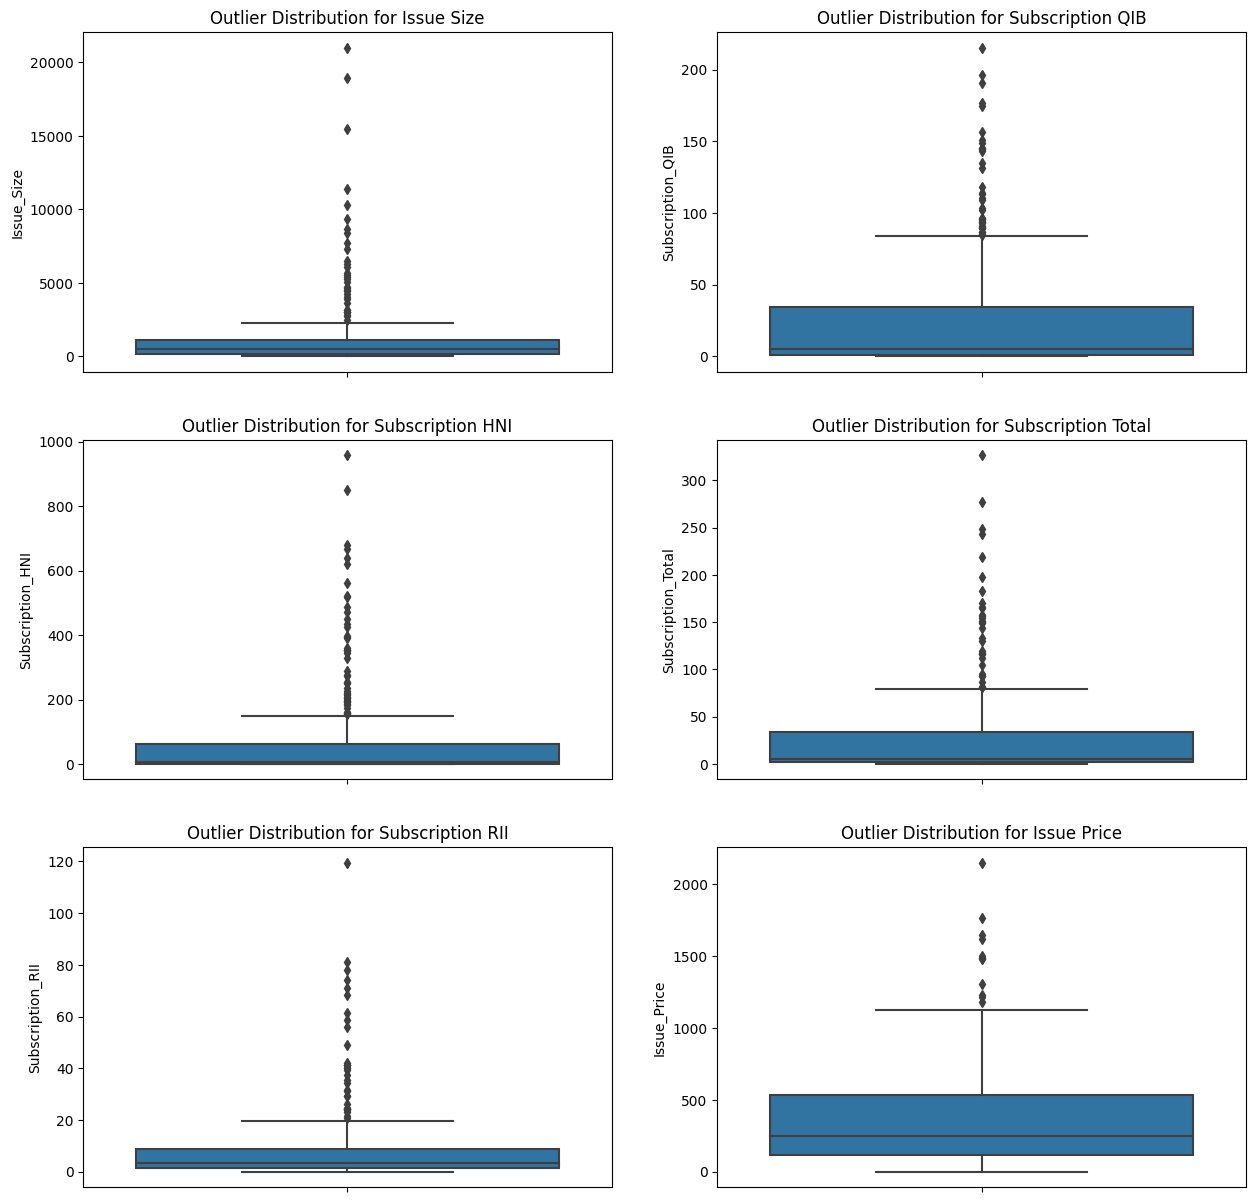

In [12]:
target_variable = ['Listing_Gains_Profit']
predictors = list(set(list(ipo.columns)) - set(target_variable))

figure = plt.figure(figsize = (15, 15))
for fig, category in zip(range(1,7), predictors):
    ax = plt.subplot(3, 2, fig)
    sns.boxplot(data = ipo,
                  y = ipo[category], 
                  ax = ax)
    plt.title('Outlier Distribution for {}'.format(category.replace('_', ' ')))                

<AxesSubplot: >

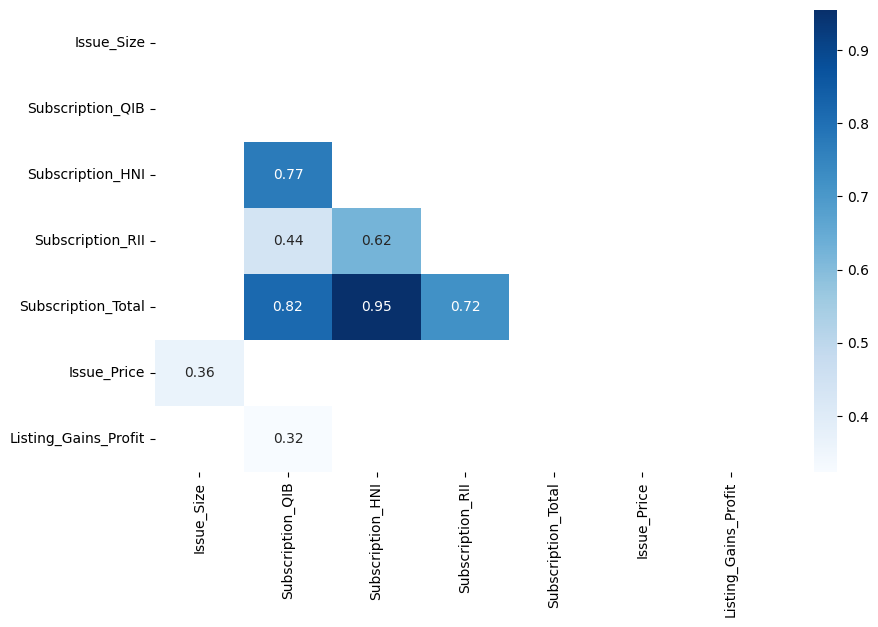

In [13]:
correlations = ipo.corr()
mask = np.triu(np.ones_like(correlations, dtype=bool))
plt.figure(figsize=(10,6))
sns.heatmap(correlations[abs(correlations) >= 0.3], mask = mask, annot=True, cmap="Blues")

### __Visualization Findings__

1. Our numerical variables all seem to skew right with outliers in the upper end. These will need treatment
2. There are slightly more listings that presented profits vs not
3. Subscription variables are correlated between themselves, but the Qualified Institutional Buyer has the strongest correlation to Profits

## __Outlier Treatment__

Now that we determined we have have some outliers, we'll fix that by replacing anything that falls under the `lower bound` and over the `upper bound` with those respective values. This will both remove outliers and help keep values within a reasonable range to not throw off predictions.

In [14]:
for col in predictors:
    q1 = ipo[col].quantile(q=0.25)
    q3 = ipo[col].quantile(q=0.75)
    iqr = q3 - q1   
    lower = (q1 - 1.5 * iqr) 
    upper = (q3 + 1.5 * iqr) 
    ipo[col] = np.where(ipo[col] > upper, upper, ipo[col]) # replace outliers with upper bound
    ipo[col] = np.where(ipo[col] <lower, lower, ipo[col]) # replace outliers with lower bound
    print('Updated {}'.format(col.replace('_',' ')), ':\n',ipo[col].describe(), '\n')

Updated Issue Size :
 count     319.000000
mean      763.561238
std       769.689122
min         0.000000
25%       169.005000
50%       496.250000
75%      1100.000000
max      2496.492500
Name: Issue_Size, dtype: float64 

Updated Subscription QIB :
 count    319.000000
mean      21.521183
std       29.104549
min        0.000000
25%        1.150000
50%        4.940000
75%       34.635000
max       84.862500
Name: Subscription_QIB, dtype: float64 

Updated Subscription HNI :
 count    319.000000
mean      40.356426
std       57.427921
min        0.000000
25%        1.255000
50%        5.070000
75%       62.095000
max      153.355000
Name: Subscription_HNI, dtype: float64 

Updated Subscription Total :
 count    319.000000
mean      20.456646
std       27.217740
min        0.000000
25%        1.645000
50%        4.930000
75%       33.395000
max       81.020000
Name: Subscription_Total, dtype: float64 

Updated Subscription RII :
 count    319.000000
mean       6.060940
std        6.176

## Normalizing Predictor Variables__

Now that we've removed outliers, the final step before getting into predictions is to normalize our predictor variables. Since each variable has a different range, if we took them as is each variable would have a different weight to them. To solve this, we'll transform the values in the predictor variables to be a proportion of their respective maximum value. This will ensure that each number in those columns only ranges from 0 to 1.

In [15]:
ipo[predictors] = ipo[predictors] / ipo[predictors].max()
ipo.describe()

,Issue_Size,Subscription_QIB,Subscription_HNI,Subscription_RII,Subscription_Total,Issue_Price,Listing_Gains_Profit
count,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000
mean,0.305854,0.253601,0.263157,0.309232,0.252489,0.311793,0.545455
std,0.308308,0.342961,0.374477,0.315147,0.335939,0.268853,0.498712
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.067697,0.013551,0.008184,0.065051,0.020304,0.102454,0.000000
50%,0.198779,0.058212,0.033061,0.174490,0.060849,0.215239,1.000000
75%,0.440618,0.408131,0.404910,0.439031,0.412182,0.461472,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


As explained above, now all of our variables have values that fall between 0 and 1, which helps with keeping any of them from having a disproportionate weight in the final predictions.

## __Train/Test Split: the Holdout Validation Approach__

So, how do we make sure that our model is working as intended and not over-fitting? One way to do this is through the `train_test_split` function from `scikit-learn`.

As the name suggests, we will be using this to split our data into a training set and a test set. The model will then be fit to the training data, and evaluated on both sets. Of course, any results from evaluating on the training set will be optimistic, so we'll consider it a success if the accuracy on the test set is similar to that in the training set.

If the training set accuracy is much higher, then we probably overfit the model to our training data and will have to re-evaluate our approach.

We've already imported the relevant function at the beginning. We will use 70% of our data for training, and we will set a random state seed for reproducibility:

In [16]:
X = ipo[predictors].values
y = ipo[target_variable].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=100)
print(X_train.shape); print(X_test.shape)

(223, 6)
(96, 6)


## __Defining then Deep Learning Classification Model__

Now, we are finally ready to define our mode. Again, we will greate a random_state seed for reproducibility. We will instantiate a Deep model with the `Sequential` class from Tensorflow's `Keras`. The model architecture is comprised of four hidden layers with relu as the activation function. The output layer uses a sigmoid activation function, which is a good choice for a binary classification model.

In [17]:
# define model
tf.random.set_seed(100)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(32, input_shape = (X_train.shape[1],), activation = 'relu'))
model.add(tf.keras.layers.Dense(16, activation= 'relu'))
model.add(tf.keras.layers.Dense(8, activation= 'relu'))
model.add(tf.keras.layers.Dense(4, activation= 'relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))    

## __Compiling and Training the Model__

Now that we instantiated our model, we will compile it. To do so, we need three things:

1. An optimizer: We will use a popular function for this, `Adam()`
2. A loss function: We will use `BinaryCrossentropy`. This loss function is useful for binary classification applications
3. An evaluation metric: we will use `accuracy`, since our main goal is to know if this model can predict if an IPO produced profits or not

In [18]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                224       
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
 dense_3 (Dense)             (None, 4)                 36        
                                                                 
 dense_4 (Dense)             (None, 1)                 5         
                                                                 
Total params: 929
Trainable params: 929
Non-trainable params: 0
_________________________________________________________________


With these things done, we can not fit the model to our training data. We have to set an appropriate number of epochs to train the model, and we'll use 250 iterations this time:

In [20]:
model.fit(X_train, y_train, epochs = 250)

Epoch 1/250
7/7 [==============================] - 1s 8ms/step - loss: 0.6826 - accuracy: 0.5605
Epoch 2/250
7/7 [==============================] - 0s 1ms/step - loss: 0.6790 - accuracy: 0.5561
Epoch 3/250
7/7 [==============================] - 0s 1ms/step - loss: 0.6769 - accuracy: 0.5561
Epoch 4/250
7/7 [==============================] - 0s 1ms/step - loss: 0.6729 - accuracy: 0.5561
Epoch 5/250
7/7 [==============================] - 0s 1ms/step - loss: 0.6699 - accuracy: 0.5561
Epoch 6/250
7/7 [==============================] - 0s 13ms/step - loss: 0.6664 - accuracy: 0.5561
Epoch 7/250
7/7 [==============================] - 0s 1ms/step - loss: 0.6629 - accuracy: 0.5561
Epoch 8/250
7/7 [==============================] - 0s 1ms/step - loss: 0.6598 - accuracy: 0.5561
Epoch 9/250
7/7 [==============================] - 0s 13ms/step - loss: 0.6558 - accuracy: 0.5561
Epoch 10/250
7/7 [==============================] - 0s 1ms/step - loss: 0.6519 - accuracy: 0.5561
Epoch 11/250
7/7 [=========

## __Evaluating the Model__

Now that we have fit the model to the training data, it is finally time to evaluate its accuracy. This is important for future improvements.

We will now asses the model's accuracy with both the training and testing data, so that we can control for over-fitting:

In [21]:
model.evaluate(X_train, y_train)

7/7 [==============================] - 0s 1ms/step - loss: 0.5224 - accuracy: 0.7444


[0.5224344730377197, 0.7443946003913879]

In [22]:
model.evaluate(X_test, y_test)

3/3 [==============================] - 0s 2ms/step - loss: 0.7280 - accuracy: 0.6875


[0.7280004024505615, 0.6875]

The model evaluation output shows the performance of the model on both training and test data. The accuracy was approximately 75% on the training data and 74% on the test data. Ideally, the higher the accuracy value, the better the model is performing. It's noteworthy that the training and test set accuracies are close to each other, which shows that there is consistency and that the accuracy doesn't drop too much when we test the model on unseen data.

In this project, we have built Deep Learning Classification models using the deep learning framework, Keras, in TensorFlow. We used a real-world IPO dataset and built a classifier algorithm to predict whether an IPO will list at profit or not.

## __Conclusions__

We used the Sequential API to build the model, which is achieving a decent accuracy of 75% and 74% on training and test data, respectively. We see that the accuracy is consistent across the training and test datasets, which is a promising sign.

This is just one of the many ways to model this solution — you can try out different combinations to further improve model performance.

## __Next Steps__

- `Hyperparameter Optimization`: tuning the hyperparameters like learning rate, number of layers, etc., is important for finding the optimal configuration of the deep learning model.

- `Optimizers and Loss Functions`: we could use different optimizers and loss functions to see which one improves the model performance.

- `Features`: instead of using the base predictors in the data, we could try to construct new features that might help improve the model's predictive ability.

- `Performance Metrics`: instead of using accuracy as the performance metric, we could try other performance metrics to see if that helps guide the model toward better results.

- `Domain Specific Knowledge`: using domain specific knowledge to adjust the model can further enhance its performance and accuracy.